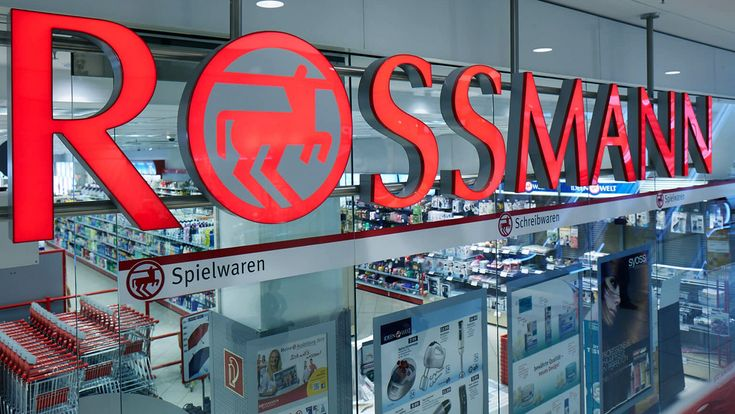

# Business Problem Description

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can vary significantly.

In their first Kaggle competition, Rossmann is challenging participants to predict six weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will assist store managers in staying focused on what’s most important to them: their customers and their teams!

## Evaluation

Submissions are evaluated on the Root Mean Square Percentage Error (RMSPE). The RMSPE is calculated as follows:

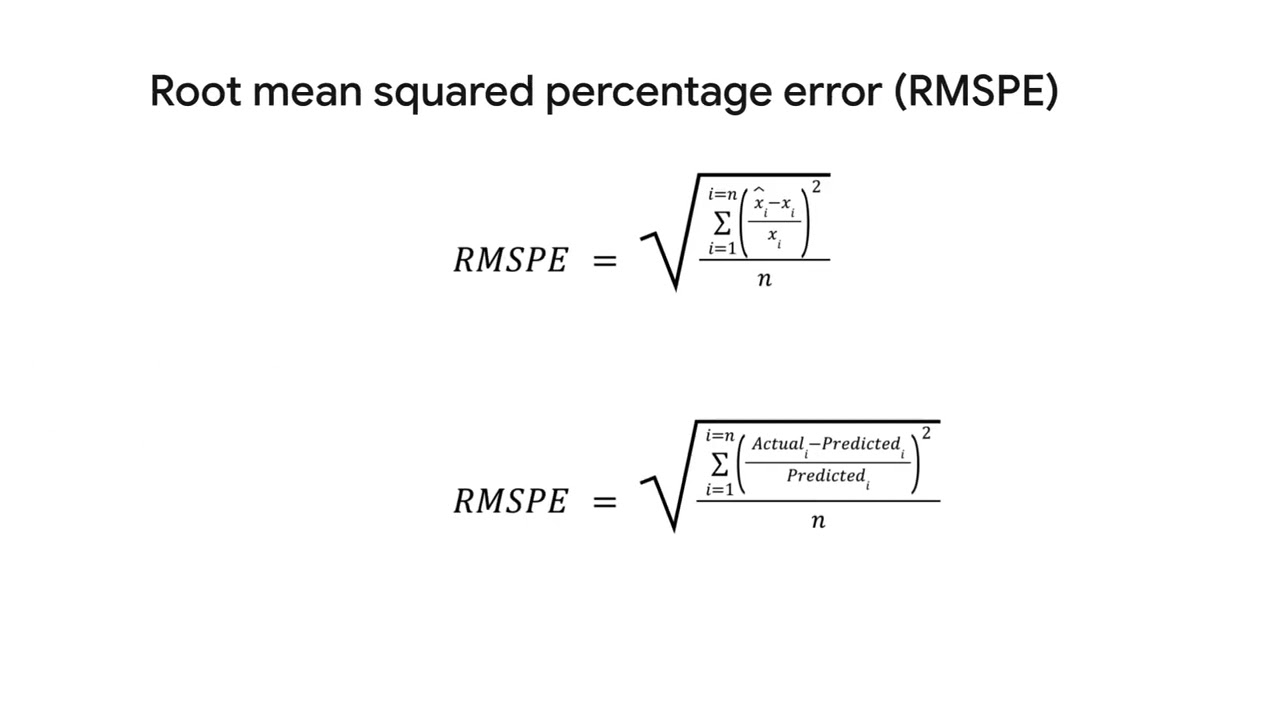


where \(x_i\) denotes the sales of a single store on a single day and \(\hat{x_i}\) denotes the corresponding prediction. Any day and store with 0 sales are ignored in scoring.

## Submission File
The submission file should contain a header and have the following format:


# Dataset Description

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## Files
- **train.csv**: historical data including Sales
- **test.csv**: historical data excluding Sales
- **sample_submission.csv**: a sample submission file in the correct format
- **store.csv**: supplemental information about the stores

## Data Fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- **Id**: an Id that represents a (Store, Date) duple within the test set
- **Store**: a unique Id for each store
- **Sales**: the turnover for any given day (this is what you are predicting)
- **Customers**: the number of customers on a given day
- **Open**: an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday**: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday**: indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType**: differentiates between 4 different store models: a, b, c, d
- **Assortment**: describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance**: distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]**: gives the approximate year and month of the time the nearest competitor was opened
- **Promo**: indicates whether a store is running a promo on that day
- **Promo2**: Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]**: describes the year and calendar week when the store started participating in Promo2
- **PromoInterval**: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


# Import Libraries

In [34]:
# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Plotting Libraries
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import balanced_accuracy_score
import statsmodels.api as sm

# Ignore w__warnings 
import warnings
warnings.filterwarnings("ignore")

# Load Datasets

In [30]:
raw_store_df = pd.read_csv('store.csv')
print(f"raw_store_df shape: {raw_store_df.shape}")
raw_store_df


raw_store_df shape: (1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# Load Train and Test Dataset

In [31]:
raw_train_df = pd.read_csv('train.csv')
raw_test_df = pd.read_csv('test.csv')
print(f"raw_train_df shape: {raw_train_df.shape}")
print(f"raw_test_df shape: {raw_test_df.shape}")

raw_train_df shape: (1017209, 9)
raw_test_df shape: (41088, 8)


# Merge store df and train df for better prediction

In [32]:
train_merged_df = raw_train_df.merge(raw_store_df, how='left', on='Store')
train_merged_df = train_merged_df.drop(['PromoInterval'], axis=1)
train_merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN


# Merge store df and test df

In [33]:
test_merged_df = raw_test_df.merge(raw_store_df, how='left', on='Store')
test_merged_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# Propensity Scores
## Propensity Score Matching will balance the data by creating comparable treatment (e.g., days with promotion) and control (e.g., days without promotion) groups.

In [39]:
# Define treatment (e.g., Promo) and control groups
data = raw_train_df.copy()
data['Promo'] = data['Promo'].astype(int)  # Ensure Promo is binary
# Updated feature list based on available columns
psm_features = ['Store', 'DayOfWeek', 'Customers', 'Open', 'SchoolHoliday']

# Select features and target for Propensity Score Matching
X = data[psm_features]
y = data['Promo']

# Proceed with the Propensity Score Matching as before
from sklearn.linear_model import LogisticRegression

# Fit logistic regression model to estimate propensity scores
logistic = LogisticRegression()
data['propensity_score'] = logistic.fit(X, y).predict_proba(X)[:, 1]

# Display sample data with propensity scores
print(data[['Store', 'Sales', 'Promo', 'propensity_score']].head())

   Store  Sales  Promo  propensity_score
0      1   5263      1          0.280012
1      2   6064      1          0.293034
2      3   8314      1          0.331320
3      4  13995      1          0.478603
4      5   4822      1          0.280707


### Business Impact of Propensity Score Matching (PSM)

**Objective of Propensity Score Matching**  
Propensity Score Matching (PSM) is used to create a fair comparison between stores with promotions (`Promo=1`) and those without (`Promo=0`). By balancing these groups based on similar characteristics (e.g., `DayOfWeek`, `Customers`, `Open` status), PSM minimizes biases, allowing us to isolate the true effect of promotions on sales.

**Understanding Propensity Scores**  
Each store is assigned a **propensity score**, representing the likelihood that it would have a promotion based on its features. For example, a score of 0.28 suggests a 28% probability of promotion based on characteristics like customer traffic, day of the week, etc. Stores with similar scores are matched, ensuring that differences in sales are likely due to the promotion itself rather than other factors.

**Business Insights Gained**  
1. **Accurate Promotion Impact Measurement**: By matching stores with and without promotions more accurately, we can evaluate how much promotions truly affect sales, avoiding misleading conclusions.
   
2. **Informed Promotional Strategy**: With a clearer view of promotion impact, we can tailor future promotional efforts. For instance, if promotions show a strong positive impact on high-propensity stores, Rossmann can focus promotions on similar stores to maximize returns.

3. **Resource Optimization**: If certain stores consistently see low sales impact from promotions, resources can be redirected more effectively, focusing on locations with a higher propensity to benefit from promotions.

**Example Outcome**  
If analysis reveals that stores with a propensity score above 0.3 experience a substantial sales increase during promotions, Rossmann can use this insight to strategically target promotions at stores with similar profiles. This approach ensures optimal promotional spend, increased sales, and enhanced customer reach.

### Summary
Propensity Score Matching provides Rossmann with **data-backed insights to optimize promotional strategies**, ensuring that investments in promotions yield maximum value by targeting stores where promotions are most effective.


# Exploratory Data Analysis

In [ ]:
# Check weather any null value in the columns

train_merged_df.isnull().sum()

In [ ]:
# Check unique value in each column

train_merged_df.nunique()

In [8]:
# There should be 4 unique values but has 5. See Next for Solution!
train_merged_df.StateHoliday.value_counts()

StateHoliday
0    855087
0    131072
a     20260
b      6690
c      4100
Name: count, dtype: int64

In [9]:
# Replacing string '0' as integer '0' 

train_merged_df['StateHoliday'].replace({'0': 0}, inplace=True)
test_merged_df['StateHoliday'].replace({'0': 0}, inplace=True)
train_merged_df.StateHoliday.value_counts()

StateHoliday
0    986159
a     20260
b      6690
c      4100
Name: count, dtype: int64

<Axes: xlabel='Sales', ylabel='Count'>

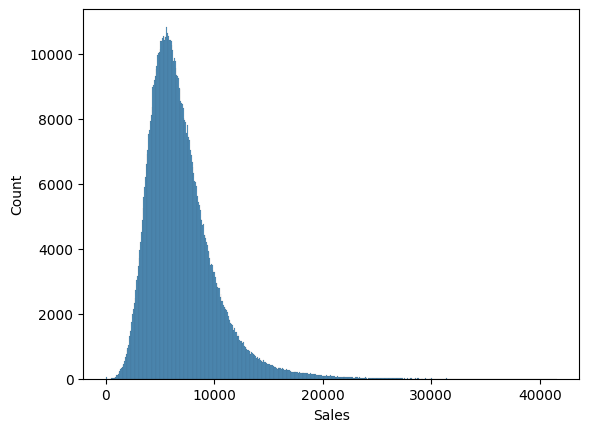

In [10]:
"""
When the store is closed, the sales amount is recorded as zero. Therefore, rows with zero sales are not meaningful.
It is more efficient to eliminate rows where the store is closed. 
"""

reduced_train_df = train_merged_df[ train_merged_df.Open == 1 ].copy()

# Distribution of target column named 'sales'
sns.histplot(data=reduced_train_df, x='Sales')

<Axes: xlabel='Assortment', ylabel='Count'>

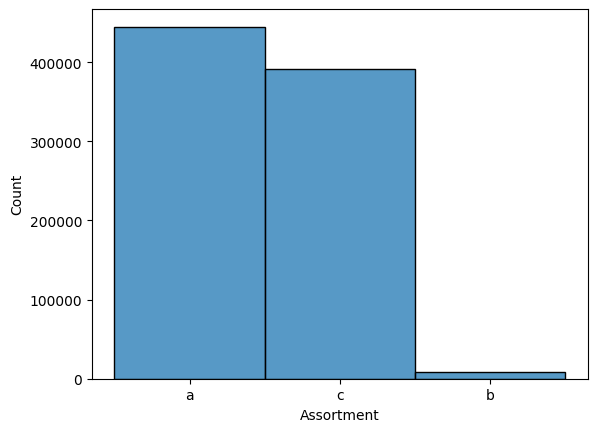

In [11]:
# Distribution of target column named 'sales'
sns.histplot(data=reduced_train_df, x='Assortment')

Text(0.5, 1.0, 'Sales vs Customers')

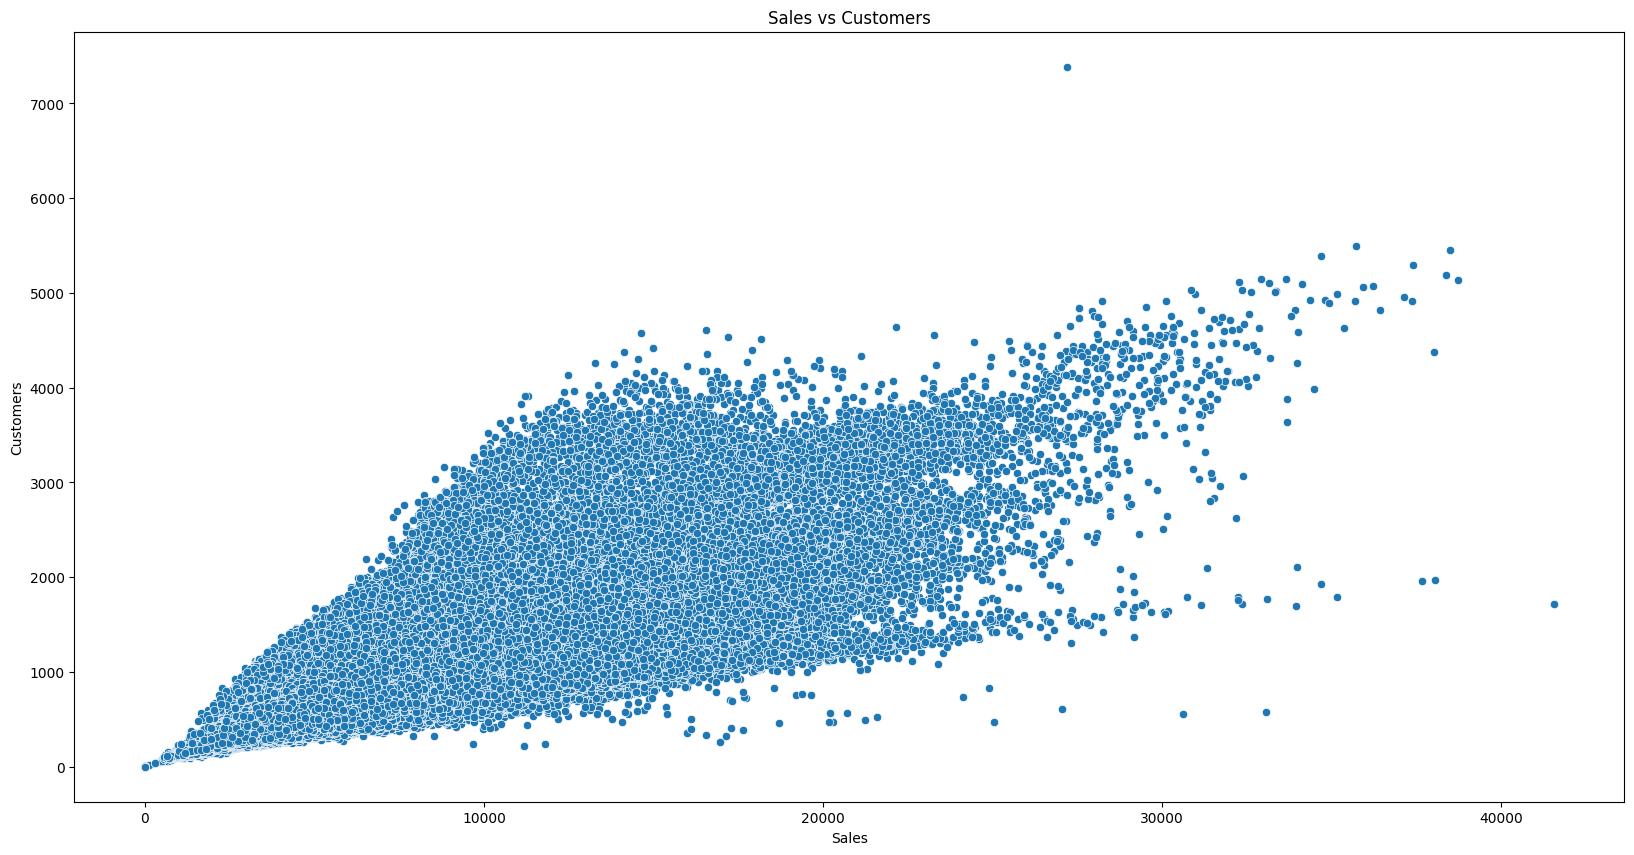

In [12]:
plt.figure(figsize=(20, 10))
# Sales vs Customers Scatter Plot
sns.scatterplot(x=reduced_train_df.Sales, y=reduced_train_df.Customers)
plt.title("Sales vs Customers")

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

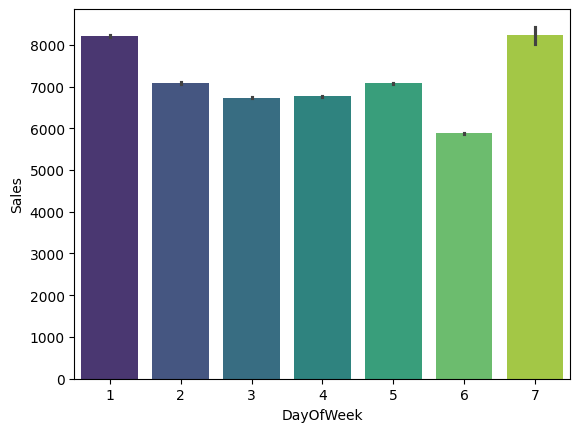

In [13]:
sns.barplot(x=reduced_train_df.DayOfWeek, y=reduced_train_df.Sales, palette='viridis')

<Axes: xlabel='StateHoliday', ylabel='Sales'>

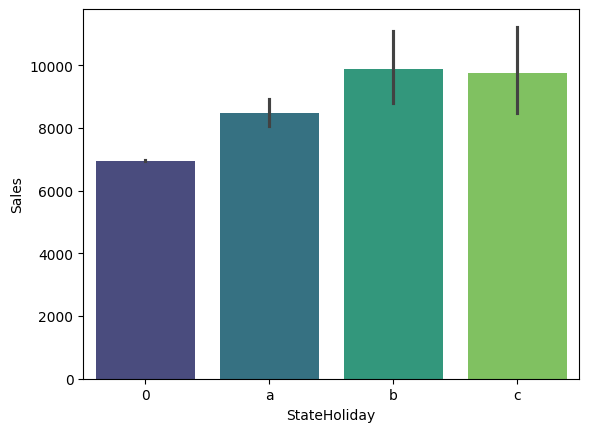

In [14]:
sns.barplot(data=reduced_train_df, x='StateHoliday', y='Sales', palette='viridis')

<Axes: xlabel='Assortment', ylabel='Sales'>

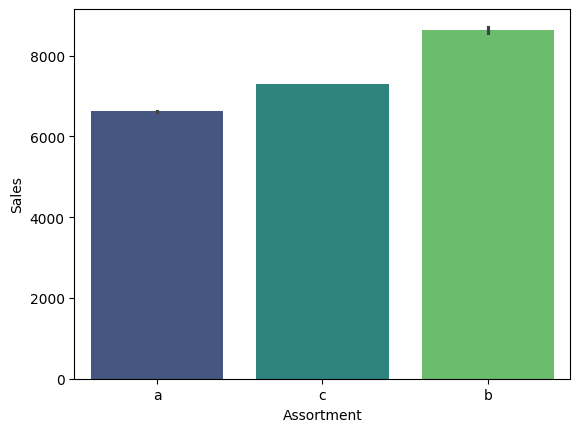

In [15]:
""" 
Assortment - describes an assortment level: a = basic, b = extra, c = extended """
sns.barplot(data=reduced_train_df, x='Assortment', y='Sales', palette='viridis')

<Axes: xlabel='StoreType', ylabel='Sales'>

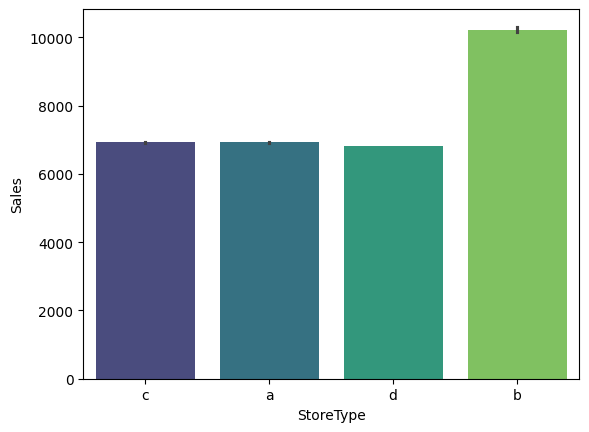

In [16]:
sns.barplot(data=reduced_train_df, x='StoreType', y='Sales', palette='viridis')

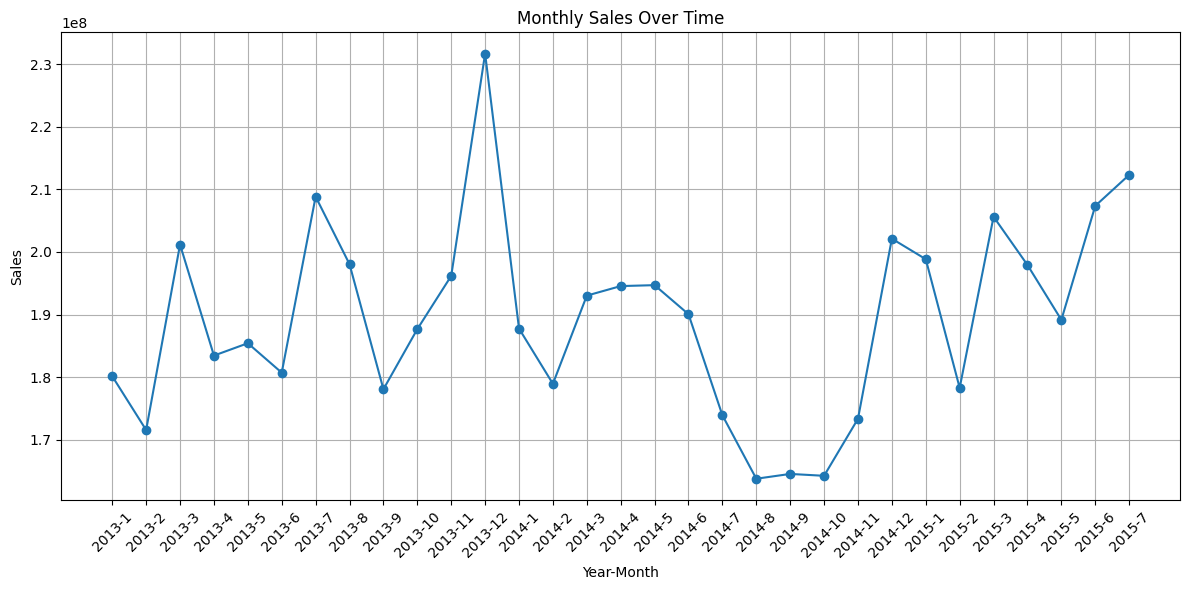

In [17]:
# Visualizing sales for each month over time

# Convert 'Date' column to datetime format
reduced_train_df['Date'] = pd.to_datetime(reduced_train_df['Date'])

# Extracting year and month from the 'Date' column
reduced_train_df['Year'] = reduced_train_df['Date'].dt.year
reduced_train_df['Month'] = reduced_train_df['Date'].dt.month
reduced_train_df['Day'] = reduced_train_df['Date'].dt.day

# Grouping by year and month, and summing up the sales for each group
monthly_sales = reduced_train_df.groupby(['Year', 'Month'])['Sales'].sum().reset_index()

# Plotting the monthly sales trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str), monthly_sales['Sales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

# Split the Dataset

In [18]:
""" 
Preparing Test Datasets:

1) Access the test.csv data and merge it with store.csv.
2) Convert the Datetime string column to pandas datetime format for improved handling of the Date column.
3) Create three new columns: year, month, and day, similar to those in the training dataset.

"""

test_merged_df['Date'] = pd.to_datetime(test_merged_df.Date)

test_merged_df['Year'] = test_merged_df.Date.dt.year
test_merged_df['Month'] = test_merged_df.Date.dt.month
test_merged_df['Day'] = test_merged_df.Date.dt.day

print(f"Estimate Sales from {test_merged_df.Date.dt.date.min()} to {test_merged_df.Date.dt.date.max()}")
test_merged_df

Estimate Sales from 2015-08-01 to 2015-09-17


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,9,17
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN,2015,9,17
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN,2015,9,17
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN,2015,9,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2015,8,1
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2015,8,1
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2015,8,1
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2015,8,1


In [19]:
train_df = reduced_train_df[reduced_train_df.Date.dt.year <= 2014]
val_df = reduced_train_df[reduced_train_df.Date.dt.year == 2015]

print(f"Training Shape: {train_df.shape}")
print(f"Validation Shape: {val_df.shape}")
print(f"Test Shape: {test_merged_df.shape}")

Training Shape: (648360, 20)
Validation Shape: (196032, 20)
Test Shape: (41088, 20)


# Data Processing

In [20]:
# choose columns to train and target

# Set columns for training
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'StoreType', 'Assortment', 'Promo2', 'Day', 'Month', 'Year']
# Set Target Column
target_col = 'Sales'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_merged_df[input_cols].copy()

num_cols = ['Store', 'DayOfWeek', 'Day', 'Month', 'Year']
cat_cols = ['DayOfWeek', 'Promo', 'StoreType', 'Assortment', 'Promo2']

In [21]:
# Encoding

train_inputs = pd.get_dummies(train_inputs)
val_inputs = pd.get_dummies(val_inputs, drop_first=False)
test_inputs = pd.get_dummies(test_inputs)

# Drop the columns that are not in test dataset
train_inputs = train_inputs.drop(['StateHoliday_b', 'StateHoliday_c'], axis=1)
val_inputs = val_inputs.drop(['StateHoliday_b'], axis=1)

In [22]:
# Scaling

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(train_inputs[num_cols])

# Based on the learning from training datasets, val_df and test_df columns sclaed!
train_inputs[num_cols] = scaler.transform(train_inputs[num_cols])
val_inputs[num_cols] = scaler.transform(val_inputs[num_cols])
test_inputs[num_cols] = scaler.transform(test_inputs[num_cols])

# Selecting a Model

In [23]:
"""
Since the prediction will be assessed using the RMSPE metric, please create a custom rmspe function.

"""
def rmspe(y_true, y_pred):
    """
    Compute the Root Mean Square Percentage Error (RMSPE) between the true and predicted values.
    
    Parameters:
    - y_true: array-like, true target values
    - y_pred: array-like, predicted target values
    
    Returns:
    - float, RMSPE value
    """
    # Ensure both arrays have the same length
    assert len(y_true) == len(y_pred)
    
    # Compute the percentage error for each observation
    percentage_error = (y_true - y_pred) / y_true
    
    # Exclude observations where true value is zero
    percentage_error[y_true == 0] = 0
    
    # Square the percentage errors
    squared_percentage_error = percentage_error ** 2
    
    # Compute the mean of the squared percentage errors
    mean_squared_percentage_error = np.mean(squared_percentage_error)
    
    # Compute the square root of the mean squared percentage error
    rmspe = np.sqrt(mean_squared_percentage_error)
    
    return rmspe # Convert to percentage

In [24]:
# A helper function to automate task of fitting model and evaluating

def try_model(model):
    model.fit(train_inputs, train_targets)

    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)

    # Get RMSE
    train_rmse = np.round(mean_squared_error(train_targets, train_preds, squared=False), 5)
    val_rmse = np.round(mean_squared_error(val_targets, val_preds, squared=False), 5)

    # Get RMSPE
    train_rmspe = np.round(rmspe(train_targets, train_preds), 5)
    val_rmspe = np.round(rmspe(val_targets, val_preds), 5)


    print(f"Train RMSE: {train_rmse}")
    print(f"Val RMSE: {val_rmse}")
    print()
    print(f"Train RMSPE: {train_rmspe}")
    print(f"Val RMSPE: {val_rmspe}")

    return model

In [25]:
# Creating a dumb model that can predict average sales only
        
def get_mean(input):
    return np.full(len(input), reduced_train_df.Sales.mean())

dum_train_preds = get_mean(train_df)
dum_val_preds = get_mean(val_df)

from sklearn.metrics import mean_squared_error

# Get root mean squared error
dum_train_eval = mean_squared_error(dum_train_preds, train_targets, squared=False)
dum_val_eval = mean_squared_error(dum_val_preds, val_targets, squared=False)

train_rmspe = rmspe(dum_train_preds, train_targets)
val_rmspe = rmspe(dum_val_preds, val_targets)

print(f"train_rmse: {dum_train_eval}")
print(f"val_rmse: {dum_val_eval}")
print()
print(f"train_rmspe: {train_rmspe}")
print(f"val_rmspe: {val_rmspe}")
      

train_rmse: 3124.212911034433
val_rmse: 3037.1262166880488

train_rmspe: 0.44917065517162236
val_rmspe: 0.4366501296280081


# Linear Regression as a Base Model

In [26]:
logit_model = LinearRegression()
try_model(logit_model)

Train RMSE: 2787.2088
Val RMSE: 2694.56185

Train RMSPE: 0.5379
Val RMSPE: 0.47785


LinearRegression()

# Decision Tree Regressor

In [27]:
decision_tree_model = DecisionTreeRegressor(random_state=42)
try_model(decision_tree_model)

Train RMSE: 0.0
Val RMSE: 1380.17354

Train RMSPE: 0.0
Val RMSPE: 0.21355


DecisionTreeRegressor(random_state=42)

# Random Forest

In [28]:
random_forest_model = RandomForestRegressor(random_state=42, 
                                            n_jobs=-1)
try_model(random_forest_model)

MemoryError: could not allocate 67108864 bytes

# Submission

In [ ]:
test_preds = random_forest_model.predict(test_inputs)
submission_df = pd.read_csv('sample_submission.csv')
submission_df['Sales'] = test_preds
submission_df.to_csv('submission.csv', index=False)

# Feature Importance

In [ ]:
feature_importance_df = pd.DataFrame({ 
    'feature': train_inputs.columns, 
    'importance': random_forest_model.feature_importances_
}).sort_values('importance', ascending=False)
feature_importance_df

# Visualizing the important features

In [ ]:
# Plot to visualize most important feature
sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='viridis')

# Conclusion

## Feature Importance Analysis

The analysis of feature importance reveals the following insights:

- **Store**: **Importance Score: 0.565**  
  This feature has the highest significance, indicating a substantial impact on sales.

- **Promo**: **Importance Score: 0.134**  
  Promotional activities significantly contribute to sales performance.

- **DayOfWeek**: **Importance Score: 0.068**  
  This feature is an influential factor, albeit to a lesser extent.

- **Day**: **Importance Score: 0.060**  
  Also identified as an influential factor in determining sales outcomes.

These insights highlight the pivotal role of store-related factors and promotional strategies in driving sales revenue.
